In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from odps import ODPS
from odps import options
import oss2
from odps.df import DataFrame
import datetime
import pandas as pd
import numpy as np
import threading
import queue
import time

# connect信息
from ACCESS import ACCESS_ID
from ACCESS import SECRET_ACCESS_KEY
from ACCESS import ODPS_PROJECT
from ACCESS import ODPS_ENDPOINT

# # 此为外网地址
OSS_ENDPOINT = 'http://oss-cn-shanghai.aliyuncs.com'
OSS_BUCKET = 'hypertrons'

# oss实例
auth = oss2.Auth(ACCESS_ID, SECRET_ACCESS_KEY)
bucket = oss2.Bucket(auth, OSS_ENDPOINT, OSS_BUCKET)

# 创建odps实例
o = ODPS(ACCESS_ID, SECRET_ACCESS_KEY, project=ODPS_PROJECT, endpoint=ODPS_ENDPOINT)
options.tunnel.limit_instance_tunnel = False
# options.read_timeout = 3600000

hints = {'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'}

#### Degree Centrality

##### 度中心性衡量网络中一个节点与所有其它节点相联系的程度

In [38]:
# 入度

select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT repo_org_id, repo_org_login, count(actor_org_id) AS count
    FROM Yue_ORG_To_ORG
    GROUP BY repo_org_id, repo_org_login
    ORDER BY count DESC
    '''.format(
        TEMP_TABLE_NAME='Yue_ORG_To_ORG'
    )
table = o.execute_sql(select_sql, hints={'odps.sql.allow.fullscan': 'true', 'odps.sql.submit.mode': 'script'})

login_in = []
degree_in = []
i=0
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        print(record.repo_org_id, record.repo_org_login, record.count)
        login_in.append(record.repo_org_login)
        degree_in.append(record.count)
        i += 1
        if i > 10:
            break
login_in.reverse()
degree_in.reverse()

1342004 google 6817
47359 apache 6311
69631 facebook 6127
1503512 Homebrew 5445
6154722 microsoft 5107
3637556 DefinitelyTyped 4816
9919 github 4772
6154722 Microsoft 4622
13629408 kubernetes 4099
761456 hashicorp 3067
5429470 docker 2823


In [39]:
list_degree = []
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        list_degree.append(record.count)
list_degree.sort(reverse=True)
list_degree_sum = sum(list_degree)
#sns.set()
#sns.distplot(list_degree)

百分之 11.468 的organization掌握了80%的入度


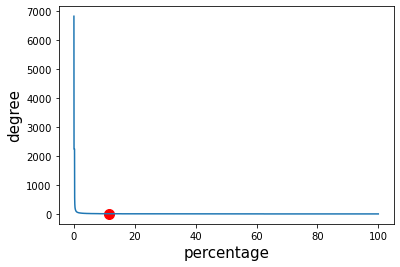

In [42]:
s = 0
for i in range(len(list_degree)):
    s += list_degree[i]
    # 80%分位数
    if s >= 0.8 * list_degree_sum:
        percentage = i / len(list_degree)
        break
print('百分之',round(percentage,5) * 100,'的organization掌握了80%的入度')

plt.plot(np.arange(0, 100, 100 / len(list_degree)),list_degree)
plt.scatter(percentage*100, list_degree[int(percentage*len(list_degree))],c=['red'],s=[100])
plt.xlabel('percentage', fontsize=15)
plt.ylabel('degree', fontsize=15)
plt.show()

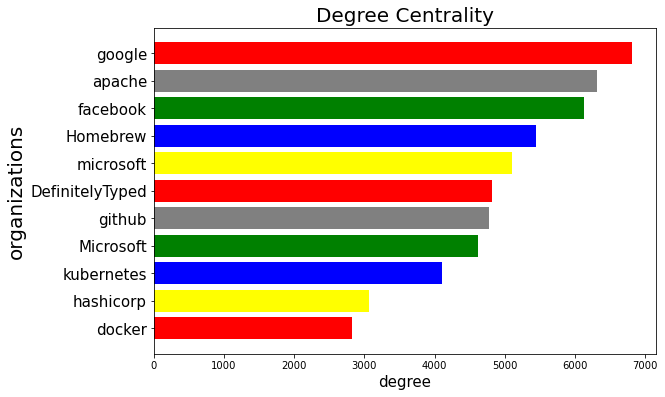

In [41]:
colors = ['red', 'yellow', 'blue', 'green', 'gray']
plt.figure(figsize=(9,6))
plt.yticks(fontsize=15)
plt.barh(login_in,degree_in,color=colors)
plt.title("Degree Centrality", fontsize=20)
plt.xlabel("degree", fontsize=15)
plt.ylabel("organizations", fontsize=20)
plt.show()

In [30]:
# 出度

select_sql = '''
    set odps.sql.validate.orderby.limit=false;
    SELECT actor_org_id, actor_org_login, count(repo_org_id) AS count
    FROM Yue_ORG_To_ORG
    GROUP BY actor_org_id, actor_org_login
    HAVING actor_org_id!= '0'
    ORDER BY count DESC
    '''
table = o.execute_sql(select_sql, hints=hints)

login_out = []
degree_out = []
i=0
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        print(record.actor_org_id, record.actor_org_login, record.count)
        login_out.append(record.actor_org_login)
        degree_out.append(record.count)
        i += 1
        if i > 10:
            break
login_out.reverse()
degree_out.reverse()

1342004 google 2910
131524 mozilla 1953
6154722 microsoft 1831
107424 jenkinsci 1332
6154722 Microsoft 1226
2810941 GoogleCloudPlatform 1219
1459110 IBM 1210
9919 github 1177
25064361 alchemycodelab 1113
66423638 IIM-Creative-Technology 1107
6844498 Azure 1087


In [31]:
list_degree_out = []
with table.open_reader(tunnel=True) as reader:
    for record in reader:
        list_degree_out.append(record.count)
list_degree_out.sort(reverse=True)
list_degree_out_sum = sum(list_degree_out)

百分之 15.4 的organization掌握了80%的出度


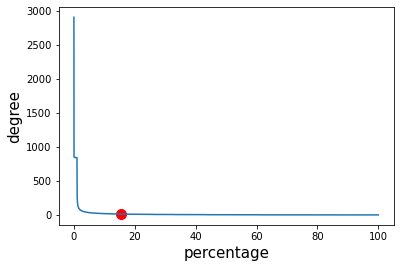

In [32]:
s = 0
for i in range(len(list_degree)):
    s += list_degree_out[i]
    # 80%分位数
    if s >= 0.8 * list_degree_out_sum:
        percentage = i / len(list_degree_out)
        break
print('百分之',round(percentage, 3) * 100,'的organization掌握了80%的出度')

plt.plot(np.arange(0, 100, 100 / len(list_degree_out)),list_degree_out)
plt.scatter(percentage*100, list_degree_out[int(percentage*len(list_degree_out))],c=['red'],s=[100])
plt.xlabel('percentage', fontsize=15)
plt.ylabel('degree', fontsize=15)
plt.show()

百分之 2.4 的organization掌握了80%的出度


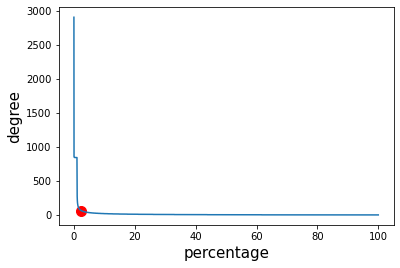

In [36]:
s = 0
for i in range(len(list_degree)):
    s += list_degree_out[i]
    if s >= 0.6 * list_degree_out_sum:
        percentage = i / len(list_degree_out)
        break
print('百分之',round(percentage, 3) * 100,'的organization掌握了80%的出度')

plt.plot(np.arange(0, 100, 100 / len(list_degree_out)),list_degree_out)
plt.scatter(percentage*100, list_degree_out[int(percentage*len(list_degree_out))],c=['red'],s=[100])
plt.xlabel('percentage', fontsize=15)
plt.ylabel('degree', fontsize=15)
plt.show()

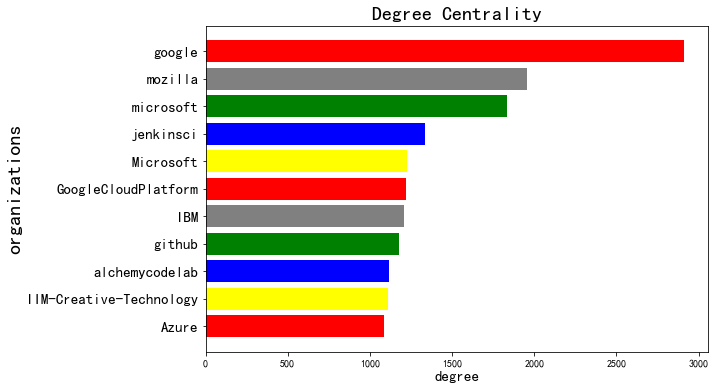

In [48]:
colors = ['red', 'yellow', 'blue', 'green', 'gray']
plt.figure(figsize=(9,6))
plt.yticks(fontsize=15)
plt.barh(login_out,degree_out,color=colors)
plt.title("Degree Centrality", fontsize=20)
plt.xlabel("degree", fontsize=15)
plt.ylabel("organizations", fontsize=20)
plt.show()

#### PageRank

In [27]:
def pint_rank():
    # 排序rank表
    sort_rank = '''
        set odps.sql.validate.orderby.limit=false;
        SELECT *
        FROM Yue_Rank
        ORDER BY rank DESC
    '''
    table = o.execute_sql(sort_rank, hints = hints)
    list_ = []
    i=0
    with table.open_reader(tunnel=True) as reader:
        for record in reader:
            print(record.org_id, record.org_login, record.rank)
            i += 1
            if i > 10:
                break

# 初始化rank表             
drop_sql = '''
DROP TABLE IF EXISTS Yue_Rank;
CREATE TABLE IF NOT EXISTS Yue_Rank
(
    org_id STRING,
    org_login STRING,
    rank DOUBLE DEFAULT 1.0,
    degree BIGINT
);
'''

o.execute_sql(drop_sql, hints=hints)

select_sql = '''
    INSERT INTO Yue_Rank (org_id, org_login, degree)
    SELECT org_id, org_login, degree
    FROM Yue_org_degree
    '''
o.execute_sql(select_sql, hints=hints)
tmp = DataFrame(o.get_table('Yue_Rank'))
print('组织数：',tmp.count())
pint_rank()

组织数： 224910
999981 nfs-ganesha 1.0
10000361 SecurityDayLille1 1.0
10000808 cincheo 1.0
1000087 elsevier-ptg-gep 1.0
10000923 fparma 1.0
10001720 Nuglif 1.0
10002920 LiferayCloud 1.0
10002920 wedeploy 1.0
10003264 MeteorPackaging 1.0
10004025 aternosorg 1.0
10004081 TreeBASE 1.0


In [28]:
# map阶段输出: weight表
create_weight = '''
DROP TABLE IF EXISTS Yue_weight;
CREATE TABLE IF NOT EXISTS Yue_weight
(
    org_id STRING,
    org_login STRING,
    weight DOUBLE
);
'''

insert_weight = '''
    INSERT INTO Yue_Weight
    SELECT 
        Yue_ORG_To_ORG.repo_org_id, 
        Yue_ORG_To_ORG.repo_org_login, 
        (Yue_Rank.rank / Yue_Rank.degree) AS weight
        
    FROM 
        Yue_ORG_To_ORG INNER JOIN Yue_Rank ON (Yue_ORG_To_ORG.actor_org_id = Yue_Rank.org_id AND Yue_ORG_To_ORG.actor_org_login = Yue_Rank.org_login)
'''

# reduce阶段输出: weight表 
create_weight_reduced = '''
DROP TABLE IF EXISTS Yue_weight_reduced;
CREATE TABLE IF NOT EXISTS Yue_weight_reduced
(
    org_id STRING,
    org_login STRING,
    weight DOUBLE
);
'''

insert_weight_reduced = '''
    INSERT INTO Yue_weight_reduced
    SELECT org_id, org_login, sum(weight)
    FROM Yue_weight
    GROUP BY org_id, org_login
'''

# 更新rank表
create_rank = '''
DROP TABLE IF EXISTS Yue_Rank;
CREATE TABLE IF NOT EXISTS Yue_Rank
(
    org_id STRING,
    org_login STRING,
    rank DOUBLE DEFAULT 1.0,
    degree BIGINT
);
'''

insert_rank = '''
    INSERT INTO Yue_Rank
    SELECT Yue_org_degree.org_id, Yue_org_degree.org_login, weight,degree
    FROM Yue_org_degree INNER JOIN Yue_weight_reduced ON 
        (Yue_org_degree.org_id = Yue_weight_reduced.org_id AND Yue_org_degree.org_login = Yue_weight_reduced.org_login)
'''

pint_rank()

for i in range(5):
    time_now = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
    print('--------------------------' + time_now + '--------------------------')
    # map
    o.execute_sql(create_weight, hints = hints)
    o.execute_sql(insert_weight, hints = hints)
    
    # reduce
    o.execute_sql(create_weight_reduced, hints = hints)
    o.execute_sql(insert_weight_reduced, hints = hints)
    
    # 输出
    o.execute_sql(create_rank, hints = hints)
    o.execute_sql(insert_rank, hints = hints)
    tmp = DataFrame(o.get_table('Yue_Rank'))
    #print('组织数：',tmp.count())
    
    # 排序
    pint_rank()

999981 nfs-ganesha 1.0
10000361 SecurityDayLille1 1.0
10000808 cincheo 1.0
1000087 elsevier-ptg-gep 1.0
10000923 fparma 1.0
10001720 Nuglif 1.0
10002920 LiferayCloud 1.0
10002920 wedeploy 1.0
10003264 MeteorPackaging 1.0
10004025 aternosorg 1.0
10004081 TreeBASE 1.0
--------------------------2022-05-17 13:47:55--------------------------
47359 apache 674.163692179935
1342004 google 559.695711229057
6154722 microsoft 468.5009162157427
69631 facebook 456.2565836781605
3637556 DefinitelyTyped 421.04612883522475
6154722 Microsoft 374.95876262036904
878437 JetBrains 373.2761145001666
1503512 Homebrew 346.8642679490225
8825476 learn-co-students 340.3641503710096
9919 github 332.1766490318775
37713493 firstcontributions 326.7744903100839
--------------------------2022-05-17 13:48:18--------------------------
1342004 google 468.0209104715816
47359 apache 450.4105577957579
69631 facebook 432.9042942339887
1503512 Homebrew 392.1495792443234
6154722 microsoft 336.69074244495107
9919 github 328.803